### Setup

In [1]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch matplotlib fastcore

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import random

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load a pre-trained pipeline

In [4]:
pipeline = DDPMPipeline.from_pretrained('google/ddpm-celebahq-256').to(device)

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/790 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

In [5]:
images = pipeline()

  0%|          | 0/1000 [00:00<?, ?it/s]

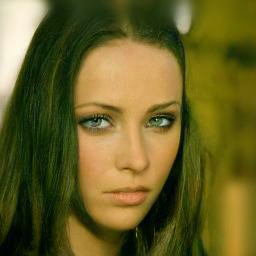

In [6]:
images.images[0]

### Faster sampling with DDIM

In [5]:
scheduler = DDIMScheduler.from_pretrained('google/ddpm-celebahq-256')
scheduler.set_timesteps(num_inference_steps=40)

In [6]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

  0%|          | 0/40 [00:00<?, ?it/s]

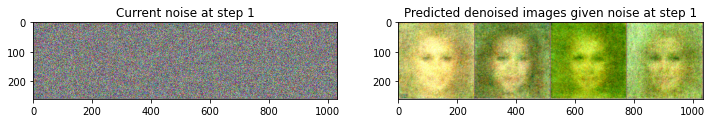

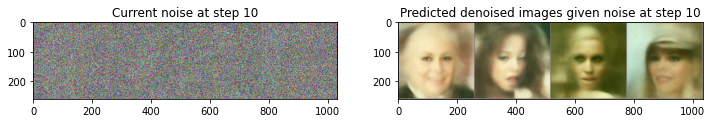

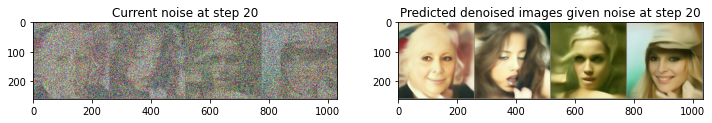

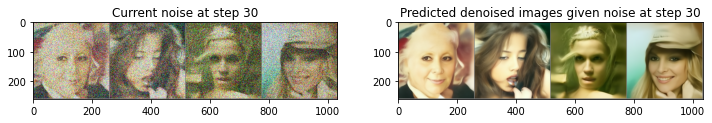

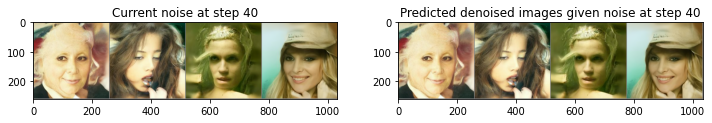

In [9]:
x = torch.randn(4, 3, 256, 256).to(device)

model = pipeline.unet
model.eval()

for i, t in enumerate(tqdm(scheduler.timesteps)):
    
    # prepare model input
    model_input = scheduler.scale_model_input(x, t)
    
    # forward pass
    with torch.inference_mode():
        noise_pred = model(model_input, t)['sample']
        
    # scheduler's step
    scheduler_output = scheduler.step(noise_pred, t, x)
    
    # update x (noise)
    x = scheduler_output.prev_sample
    
    if i == 0 or (i + 1) % 10 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        grid = torchvision.utils.make_grid(x, nrows=4).permute(1, 2, 0)
        # this part is to unnormalized the images
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5) 
        axs[0].set_title(f'Current noise at step {i + 1}')
        
        pred_x0 = scheduler_output.pred_original_sample
        grid = torchvision.utils.make_grid(pred_x0, nrows=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f'Predicted denoised images given noise at step {i + 1}')
        plt.show()

In [10]:
pipeline.scheduler = scheduler
images = pipeline(num_inference_steps=40).images

  0%|          | 0/40 [00:00<?, ?it/s]

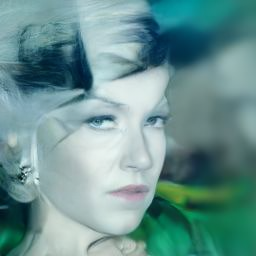

In [11]:
images[0]

### Fine-tuning

In [7]:
dataset_name = 'huggan/smithsonian_butterflies_subset'
dataset = load_dataset(dataset_name, split='train')

Using custom data configuration huggan--smithsonian_butterflies_subset-dca27cc6049931aa


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-dca27cc6049931aa/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [8]:
image_size = 256
batch_size = 4

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def preprocess_fn(examples):
    images = [preprocess(image) for image in examples['image']]
    
    return {'images': images}

dataset.set_transform(preprocess_fn)

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

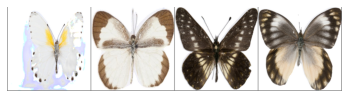

In [9]:
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch['images'], nrows=batch_size).permute(1, 2, 0)
plt.imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
plt.axis('off')
plt.show()

In [24]:
pipeline.unet.train()

epochs = 2
lr = 1e-5
grad_accumulation_steps = 2
pipeline = DDPMPipeline.from_pretrained('google/ddpm-celebahq-256').to(device)
optimizer = torch.optim.AdamW(params=pipeline.unet.parameters(), lr=lr)

losses = []


for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(tqdm(train_dataloader, leave=False)):
        images = batch['images'].to(device)
        noise = torch.randn_like(images).to(device)
        
        train_ts = scheduler.num_train_timesteps
        batch_size = images.shape[0]
        
#       # the upper bound must scheduler.num_train_steps - 1
        timesteps = torch.tensor([random.randint(0, train_ts-1) for _ in range(batch_size)]).to(device)
        # print(timesteps, timesteps.shape)
        
        # bs = clean_images.shape[0]
        # # Sample a random timestep for each image
        # timesteps = torch.randint(0, pipeline.scheduler.num_train_timesteps, (bs,), device=clean_images.device,).long()
        # print(timesteps, timesteps.shape)
        
        noisy_images = pipeline.scheduler.add_noise(images, noise, timesteps)
        
        # forward pass
        noise_pred = pipeline.unet(noisy_images, timesteps, return_dict=False)[0]
        
        # compute loss
        loss = F.mse_loss(noise_pred, noise)
        
        # keep track of losses
        losses.append(loss.item())
        
        # loss.backward
        loss.backward()
        
        # gradient accumulation
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
    print(f'Epoch: {epoch + 1} | loss: {sum(losses[-len(train_dataloader): ]) / len(train_dataloader)}')

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 1 | loss: 0.016101599734392947


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 2 | loss: 0.01360457558388589


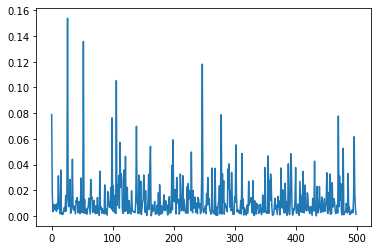

In [ ]:
plt.plot(losses);

In [30]:
x = torch.randn(8, 3, 256, 256).to(device)

model = pipeline.unet
model.eval()

for i, t in enumerate(tqdm(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    
    with torch.inference_mode():
        pred_noise = model(model_input, t)['sample']
        
        x = scheduler.step(pred_noise, t, x).prev_sample

  0%|          | 0/40 [00:00<?, ?it/s]

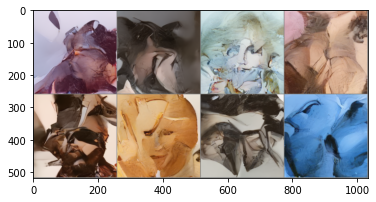

In [31]:
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)
plt.show()

In [4]:
import wandb
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from diffusers import DDPMPipeline, DDIMScheduler
from datasets import load_dataset
from PIL import Image
from tqdm.auto import tqdm
from matplotlib import pyplot
from fastcore.script import call_parse
import random

In [5]:
len(train_dl)

NameError: name 'train_dl' is not defined

In [11]:
wandb.finish()

loss,▁
loss,0.03204


In [13]:
image_size = 256
batch_size = 4
epochs = 1
lr = 1e-5
grad_accumulation_steps = 2
pretrained_model_name = 'google/ddpm-bedroom-256'
dataset_name = 'huggan/smithsonian_butterflies_subset'
device = 'cuda'
model_save_name = 'wikiart_1e'
wandb_project = 'dm_finetune'
log_sample_every = 50
save_model_every = 2500
seed = 42

wandb.init(project=wandb_project)

# initialized pretrained pipeline
pipeline = DDPMPipeline.from_pretrained(pretrained_model_name).to(device)

# initialized pretrained sampling scheduler
sampling_scheduler = DDIMScheduler.from_pretrained(pretrained_model_name)
sampling_scheduler.set_timesteps(num_inference_steps=50)

# prepare dataset
dataset = load_dataset(dataset_name, split='train')

# preprocess pipeline
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# preprocess function
def preprocess_fn(examples):
    images = [preprocess(image) for image in examples['image']]
    
    return {'images': images}

# apply preprocess function
dataset.set_transform(preprocess_fn)

# dataloader
train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# initialize optimizer and scheduler
optimizer = torch.optim.AdamW(params=pipeline.unet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

tensor2pil = transforms.ToPILImage()

for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(tqdm(train_dl, leave=False)):
        pipeline.unet.train()
        
        clean_images = batch['images'].to(device)
        noise = torch.randn_like(clean_images).to(device)
        
        batch_size = clean_images.shape[0]
        train_timesteps = pipeline.scheduler.num_train_timesteps
        timesteps = torch.tensor([random.randint(0, train_timesteps-1) for _ in range(batch_size)]).to(device)
        
        noisy_images = pipeline.scheduler.add_noise(clean_images, noise, timesteps)
        
        noise_pred = pipeline.unet(noisy_images, timesteps, return_dict=False)[0]
        
        loss = F.mse_loss(noise_pred, noise)
        wandb.log({'loss': loss.item()})
        
        loss.backward()
        
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
         
        if step == 0 or (step + 1) % log_sample_every == 0:
            generator = torch.Generator(device=device).manual_seed(seed)
            x = torch.randn((8, 3, 256, 256), device=device, generator=generator)
            pipeline.unet.eval()
        
            for i, t in enumerate(tqdm(sampling_scheduler.timesteps, leave=False)):
                model_input = sampling_scheduler.scale_model_input(x, t)
                with torch.inference_mode():
                    noise_pred = pipeline.unet(model_input, t)['sample']
                x = sampling_scheduler.step(noise_pred, t, x, generator=generator).prev_sample
                
            pred_images = x.clip(-1, 1) * 0.5 + 0.5
            wandb.log({'examples': [wandb.Image(tensor2pil(image)) for image in pred_images]})
    
    scheduler.step()

wandb.finish()

loss,▁
loss,0.01429


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Using custom data configuration huggan--smithsonian_butterflies_subset-dca27cc6049931aa
Found cached dataset parquet (/root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-dca27cc6049931aa/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

loss,▁▂▁▁▃▁▁▁█▁▁▁▁▁▁▁▃▁▁▁▁▂▁▁▁▅▁▁▁▁▁▁▂▂▁▇▁▁▁▂
loss,0.00154
